In [2]:
#####################
# IMPORT LIBS
#####################

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io, transform
from skimage.transform import AffineTransform, warp
from sklearn.metrics import roc_auc_score, mean_absolute_error
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras import backend as K

import pandas as pd
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
import albumentations as A
import cv2
import wandb
from wandb.keras import WandbCallback
import datetime



#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH / 'idao_dataset' / 'train'
PRIVATE_PATH = INPUT_PATH / 'idao_dataset' / 'private_test'
PRIVATE_PATH_NEW = INPUT_PATH / 'idao_dataset' / 'private_test_new'
PUBLIC_PATH = INPUT_PATH / 'idao_dataset' / 'public_test'

RANDOM_SEED = 4444
USE_WANDB = True

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)


if USE_WANDB:
    CURRENT_TIME = str(datetime.datetime.now()).replace(' ', '_').split('.')[0]
    RUN_NAME = 'init_rerun'

    wandb.login()
    wandb.init(project="idao-classification", name = f'{RUN_NAME}_{CURRENT_TIME}')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: artkulak (use `wandb login --relogin` to force relogin)


In [3]:
class Config:
    BATCH_SIZE = 32
    TRAINING_EPOCHS = 150
    VALIDATION_STEPS_PER_EPOCH = 5
    VALIDATION_EPOCHS = 10
    STEPS_PER_EPOCH = 30
    EARLY_STOP_PATIENCE = 5
    
    
    # Declare an augmentation pipeline
    train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        A.Cutout(num_holes=4, max_h_size=8, max_w_size=8, p=0.3),
        A.OneOf([A.RandomContrast(),
             A.RandomGamma(),
             A.RandomBrightness()],p=0.2),
        A.OneOf([A.Blur(p = 0.3),
             A.GaussNoise(p=0.3)
                ],p=0.5),
        A.CLAHE(clip_limit=4, tile_grid_size=(8,8), always_apply=False, p=0.3),
    ],)
    
    validation_transform = A.Compose([
    ],)

In [4]:
def getFeatures(img_path):
    if len(img_path.split('_')) == 18:
        particle_class = 1 # ER
        particle_energy = int(img_path.split('_')[7])
    else:
        particle_class = 0 # HE
        particle_energy = int(img_path.split('_')[8])
    return [img_path, particle_class, particle_energy]

images = glob.glob(str(TRAIN_PATH / '**/*.png'), recursive=True)
images = pd.DataFrame(map(getFeatures, images))
images.columns = ['path', 'class', 'energy']

In [5]:
#################
# EXTRACT TEST
#################

# HE - 0, ER - 1

he_test_idx = list(images[(images['class'] == 0) & (images['energy'].apply(lambda x: x in [3, 10, 30]))].index)
er_test_idx = list(images[(images['class'] == 1) & (images['energy'].apply(lambda x: x in [1, 6, 20]))].index)

In [6]:
# TODO: Write this to a separate folder

# 0 - [:750]
# 1 - [750:1502]
# 0 - [1502:7531]
# 1 - [7531:]

import glob
private_test = glob.glob(str(PRIVATE_PATH / '**/*.png'), recursive=True)
public_test = glob.glob(str(PUBLIC_PATH / '**/*.png'), recursive=True)

sample_submission = pd.read_csv(INPUT_PATH / 'track1_leak.csv')
private_ids = [t.split('/')[-1].split('.')[0] for t in private_test]
public_ids = [t.split('/')[-1].split('.')[0] for t in public_test]

sample_submission['path'] = sample_submission['id'].apply(lambda x: PRIVATE_PATH / f'{x}.png' if x in private_ids else PUBLIC_PATH / f'{x}.png').map(str)
sample_submission.iloc[:750, 1] = 1
sample_submission.iloc[750:1502, 1] = 0
sample_submission.iloc[1502:7531, 1] = 1
sample_submission.iloc[7531:, 1] = 0

sample_submission = sample_submission.iloc[1502:].reset_index(drop = True)

images_leak = pd.DataFrame(np.array([sample_submission.iloc[:, 3].values, sample_submission.iloc[:, 1].values, sample_submission.iloc[:, 2].values]).T)
images_leak.columns = ['path', 'class', 'energy']

In [7]:
indexes = np.arange(images_leak.shape[0])
np.random.shuffle(indexes)

images_leak = images_leak.iloc[indexes].reset_index(drop = True)
images = pd.concat([images, images_leak]).reset_index(drop = True)

In [8]:
test_idx = he_test_idx + er_test_idx
test_images = images.iloc[test_idx]
images = images.drop(index = test_idx)


train_images, valid_images = images.iloc[:-5000], images.iloc[-5000:] 

#train_images, valid_images = train_test_split(images, shuffle = True, random_state = RANDOM_SEED)
train_images = train_images.reset_index(drop = True)
valid_images = valid_images.reset_index(drop = True)
#valid_images = images_leak

# train_images = images.copy()

In [9]:
def calc_metric(y_binary_true, y_binary_pred, y_reg_true, y_reg_pred):
    '''
    Competition metric
    '''
    
    roc = roc_auc_score(y_binary_true, y_binary_pred)
    mae = mean_absolute_error(y_reg_true, y_reg_pred)
    return 1000 * (roc - mae), roc, mae

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, transform=None, batch_size=32,  shuffle=True, is_classification = True, augment = False):
        self.images = images
        self.indices = np.arange(len(images))
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.is_classification = is_classification
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
    
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        X = np.zeros((self.batch_size, 128, 128, 3))
        y_class = np.zeros((self.batch_size,))
        y_energy = np.zeros((self.batch_size))
        for i, idx in enumerate(batch):
            image=cv2.imread(self.images.iloc[idx, 0])
            center = image.shape[0] // 2
            image = image[center-128//2:center+128//2,center-128//2:center+128//2, :]
            X[i,] = image
            
            if self.augment:
                X[i, ] = Config.train_transform(image=X[i,].astype(np.uint8))['image']
            particle_class = self.images.iloc[idx, 1]
            particle_energy = self.images.iloc[idx, 2]
            y_class[i] = particle_class
            y_energy[i] = particle_energy
        if self.is_classification:
            return X / 255.0, y_class
        return X / 255.0, y_energy


In [11]:
train_datagen = DataGenerator(train_images, batch_size = Config.BATCH_SIZE, is_classification = True, augment = False)
valid_datagen = DataGenerator(valid_images, batch_size = Config.BATCH_SIZE, is_classification = True)
test_datagen = DataGenerator(test_images, batch_size = 1, is_classification = True, shuffle = False)

In [12]:
# Example data extract

X, y_class = train_datagen.__getitem__(0)

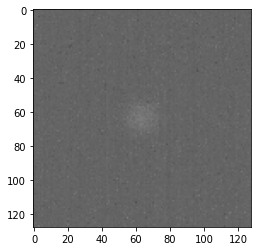

In [13]:
idx = 17
plt.imshow((X[idx] * 255).astype(np.uint8))

## Class model

In [14]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import ResNet152V2, ResNet50
from tensorflow.keras.applications import NASNetLarge, EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169

from tensorflow.keras.applications import EfficientNetB0
import numpy as np

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))

9412608/9406464 [==============================] - 0s 0us/step


In [15]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras
import tensorflow
from tensorflow.keras import regularizers

earlystop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_auc', patience=30)
ckpt = tensorflow.keras.callbacks.ModelCheckpoint(OUTPUT_PATH / 'models' / 'classification_MobileNetV2', save_best_only=True, monitor='val_auc', mode='max')
    
def create_classification_model(base_model, l2_loss_lambda = 1e-4):
    for layer in base_model.layers[:-5]:
        layer.trainable = False
        
    x = base_model.output
    x = L.GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = L.Dense(512, activation='relu')(x)
    x = L.Dense(64, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = L.Dense(1, activation='sigmoid')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)


    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics = ['AUC'])
    return model

In [16]:
model = create_classification_model(base_model)

In [17]:
if USE_WANDB:
    model.fit(
        train_datagen, 
        steps_per_epoch = Config.STEPS_PER_EPOCH, 
        validation_data = valid_datagen, 
        validation_steps = Config.VALIDATION_STEPS_PER_EPOCH, 
        epochs = Config.TRAINING_EPOCHS,
        verbose = 1,
        callbacks = [earlystop, ckpt, WandbCallback()]
        )
else:
    model.fit(
        train_datagen, 
        steps_per_epoch = Config.STEPS_PER_EPOCH, 
        validation_data = valid_datagen, 
        validation_steps = Config.VALIDATION_STEPS_PER_EPOCH, 
        epochs = Config.TRAINING_EPOCHS,
        verbose = 1,
        callbacks = [earlystop, ckpt]
        )

Epoch 1/150
30/30 [==============================] - 9s 156ms/step - loss: 0.5932 - auc: 0.7339 - val_loss: 0.7223 - val_auc: 0.6365


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../output/models/classification_MobileNetV2/assets
Epoch 2/150
30/30 [==============================] - 4s 132ms/step - loss: 0.4449 - auc: 0.8711 - val_loss: 0.7002 - val_auc: 0.6839


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../output/models/classification_MobileNetV2/assets
Epoch 3/150
30/30 [==============================] - 4s 131ms/step - loss: 0.3939 - auc: 0.8967 - val_loss: 0.6747 - val_auc: 0.6096
Epoch 4/150
30/30 [==============================] - 4s 124ms/step - loss: 0.3780 - auc: 0.9027 - val_loss: 0.6012 - val_auc: 0.7472


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../output/models/classification_MobileNetV2/assets
Epoch 5/150
30/30 [==============================] - 4s 127ms/step - loss: 0.3774 - auc: 0.9108 - val_loss: 0.7095 - val_auc: 0.8297


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../output/models/classification_MobileNetV2/assets
Epoch 6/150
30/30 [==============================] - 4s 131ms/step - loss: 0.3980 - auc: 0.9077 - val_loss: 0.6201 - val_auc: 0.6903
Epoch 7/150
30/30 [==============================] - 4s 129ms/step - loss: 0.3723 - auc: 0.9148 - val_loss: 0.7526 - val_auc: 0.7486
Epoch 8/150
30/30 [==============================] - 4s 131ms/step - loss: 0.3321 - auc: 0.9276 - val_loss: 0.6840 - val_auc: 0.6789
Epoch 9/150
30/30 [==============================] - 4s 132ms/step - loss: 0.3444 - auc: 0.9224 - val_loss: 0.9637 - val_auc: 0.7183
Epoch 10/150
30/30 [==============================] - 4s 132ms/step - loss: 0.3580 - auc: 0.9123 - val_loss: 0.9183 - val_auc: 0.7205
Epoch 11/150
30/30 [==============================] - 4s 126ms/step - loss: 0.3806 - auc: 0.9028 - val_loss: 1.7186 - val_auc: 0.6523
Epoch 12/150
30/30 [==============================] - 4s 126ms/step - loss: 0.3039 - auc: 0.9418 - val_loss: 1.012

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../output/models/classification_MobileNetV2/assets
Epoch 16/150
30/30 [==============================] - 4s 127ms/step - loss: 0.2982 - auc: 0.9446 - val_loss: 0.7524 - val_auc: 0.8383
Epoch 17/150
30/30 [==============================] - 4s 126ms/step - loss: 0.3185 - auc: 0.9331 - val_loss: 0.6044 - val_auc: 0.8351
Epoch 18/150
30/30 [==============================] - 4s 125ms/step - loss: 0.3411 - auc: 0.9278 - val_loss: 0.5063 - val_auc: 0.8419


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../output/models/classification_MobileNetV2/assets
Epoch 19/150
30/30 [==============================] - 4s 127ms/step - loss: 0.3094 - auc: 0.9351 - val_loss: 0.5504 - val_auc: 0.7724
Epoch 20/150
30/30 [==============================] - 4s 126ms/step - loss: 0.3342 - auc: 0.9281 - val_loss: 0.4575 - val_auc: 0.8380
Epoch 21/150
30/30 [==============================] - 4s 129ms/step - loss: 0.2789 - auc: 0.9456 - val_loss: 0.4014 - val_auc: 0.8769


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../output/models/classification_MobileNetV2/assets
Epoch 22/150
30/30 [==============================] - 4s 131ms/step - loss: 0.2700 - auc: 0.9450 - val_loss: 0.6057 - val_auc: 0.8371
Epoch 23/150
30/30 [==============================] - 4s 126ms/step - loss: 0.3084 - auc: 0.9348 - val_loss: 0.9122 - val_auc: 0.8753
Epoch 24/150
30/30 [==============================] - 4s 127ms/step - loss: 0.3071 - auc: 0.9362 - val_loss: 1.2699 - val_auc: 0.8506
Epoch 25/150
30/30 [==============================] - 4s 125ms/step - loss: 0.3279 - auc: 0.9227 - val_loss: 1.5763 - val_auc: 0.8034
Epoch 26/150
30/30 [==============================] - 4s 128ms/step - loss: 0.3485 - auc: 0.9139 - val_loss: 1.5932 - val_auc: 0.8114
Epoch 27/150
30/30 [==============================] - 4s 131ms/step - loss: 0.3019 - auc: 0.9341 - val_loss: 1.3918 - val_auc: 0.8095
Epoch 28/150
30/30 [==============================] - 4s 127ms/step - loss: 0.3061 - auc: 0.9357 - val_loss: 1

In [18]:
model = tensorflow.keras.models.load_model(OUTPUT_PATH / 'models' / 'classification_MobileNetV2')

In [19]:
public_loss, public_auc = model.evaluate(valid_datagen, batch_size=64, steps=valid_images.shape[0] // 64)
wandb.run.summary["public_auc"] = public_auc

78/78 [==============================] - 9s 102ms/step - loss: 0.5243 - auc: 0.8393


In [21]:
private_loss, private_auc = model.evaluate(test_datagen, batch_size=1, steps=test_images.shape[0])
wandb.run.summary["private_auc"] = private_auc

12/12 [==============================] - 0s 6ms/step - loss: 0.6812 - auc: 1.0000


In [172]:
# model.save(OUTPUT_PATH / 'models' / 'cnn_classification')

## Score calc

In [51]:
auc = lambda score_orig, score_swapped: score_orig/1000 + 1/2 * (1 - (score_swapped + score_orig)/1000) 
mae = lambda score_orig, score_swapped: 1/2 * (1 - (score_swapped + score_orig)/1000) 

In [54]:
auc(-98.88, -1006.54)

0.9538300000000001

In [55]:
mae(-98.88, -1006.54)

1.05271